<a href="https://colab.research.google.com/github/TiffanyDegbotse/Star_Struck/blob/main/Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os

kaggle_dict = {
    "username": "tiffanydegbotse",
    "key": "f867da44f8b08718e4c74e2eb26c56c9"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

!chmod 600 /root/.kaggle/kaggle.json


In [2]:
!pip install -q kaggle


In [ ]:
!kaggle competitions list | head


ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3    2026-04-15 23:59:00  Featured         2,207,152 Usd       1590           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection         2026-02-13 23:59:00  Research           200,000 Usd        788           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                   2026-02-24 23:59:00  Featured           100,000 Usd         63           False  
https://www.kaggle.com/competitions/csiro-biomass                                2026-01-28 23:59:00  Research            75,000 Usd       3858           False  
https://www.kaggle.com/compe

In [3]:
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge


 99% 1.76G/1.77G [00:18<00:00, 226MB/s]
100% 1.77G/1.77G [00:18<00:00, 103MB/s]


In [4]:
import zipfile
import os

RAW_DIR = "/content/galaxy_zoo_raw"
DATA_DIR = "/content/galaxy_zoo"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Extract the main competition zip
with zipfile.ZipFile("/content/galaxy-zoo-the-galaxy-challenge.zip", "r") as z:
    z.extractall(RAW_DIR)

os.listdir(RAW_DIR)


['images_training_rev1.zip',
 'central_pixel_benchmark.zip',
 'all_ones_benchmark.zip',
 'all_zeros_benchmark.zip',
 'images_test_rev1.zip',
 'training_solutions_rev1.zip']

Extracting images and labels

In [5]:
needed = [
    "images_training_rev1.zip",
    "training_solutions_rev1.zip"
]

for z in needed:
    with zipfile.ZipFile(os.path.join(RAW_DIR, z), "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)

print(os.listdir(DATA_DIR))


['training_solutions_rev1.csv', 'images_training_rev1']


Loading labels

In [6]:
import pandas as pd

labels = pd.read_csv("/content/galaxy_zoo/training_solutions_rev1.csv")
labels.head()
print("\nFirst few columns:")
print(labels.columns[:10].tolist())
print("\nFirst row sample:")
print(labels.iloc[0, :5])


First few columns:
['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2']

First row sample:
GalaxyID    100008.000000
Class1.1         0.383147
Class1.2         0.616853
Class1.3         0.000000
Class2.1         0.000000
Name: 0, dtype: float64


Creating Clean , Confident Labels

In [7]:
def assign_label(row):
    if row["Class1.1"] > 0.8:
        return "elliptical"
    elif row["Class1.2"] > 0.8:
        return "spiral"
    else:
        return None

labels["morphology"] = labels.apply(assign_label, axis=1)
labels = labels.dropna(subset=["morphology"])

labels["morphology"].value_counts()


,count
morphology,
spiral,16135
elliptical,8110


Sampling a small balanced dataset

In [8]:
N_PER_CLASS = 1500  # safe for Colab + hackathon

elliptical = labels[labels["morphology"] == "elliptical"].sample(
    n=N_PER_CLASS, random_state=42
)

spiral = labels[labels["morphology"] == "spiral"].sample(
    n=N_PER_CLASS, random_state=42
)

subset = pd.concat([elliptical, spiral]).reset_index(drop=True)
subset["morphology"].value_counts()


,count
morphology,
elliptical,1500
spiral,1500


Attaching image paths

In [9]:
IMG_DIR = "/content/galaxy_zoo/images_training_rev1"

subset["image_path"] = subset["GalaxyID"].apply(
    lambda x: os.path.join(IMG_DIR, f"{x}.jpg")
)

subset = subset[subset["image_path"].apply(os.path.exists)]
print("Final dataset size:", len(subset))

Final dataset size: 3000


Train/validation split

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    subset,
    test_size=0.2,
    stratify=subset["morphology"],
    random_state=42
)

train_df["morphology"].value_counts(), val_df["morphology"].value_counts()


(morphology
 spiral        1200
 elliptical    1200
 Name: count, dtype: int64,
 morphology
 spiral        300
 elliptical    300
 Name: count, dtype: int64)

Visualize some images

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

def show_examples(df, label, n=5):
    examples = df[df["morphology"] == label].sample(n=n, random_state=42)

    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(examples.iterrows()):
        img = Image.open(row["image_path"])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    plt.show()


Showing ellipticals

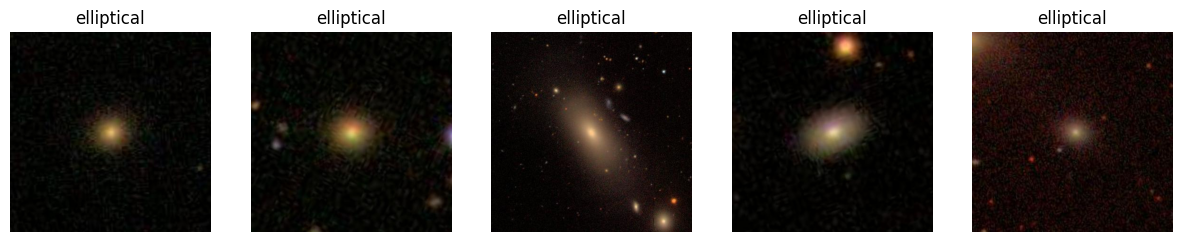

In [12]:
show_examples(subset, "elliptical", n=5)


Showing spirals

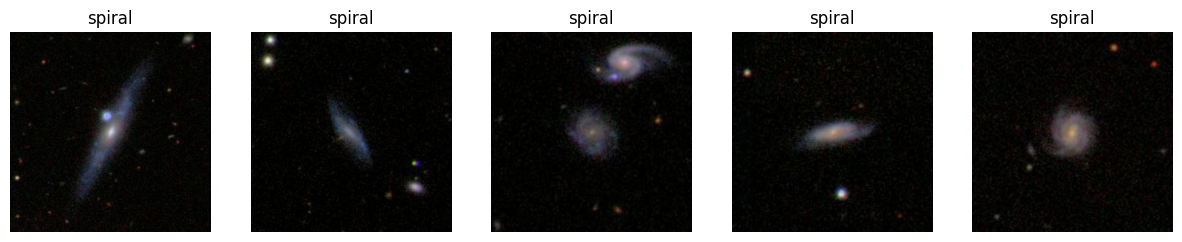

In [13]:
show_examples(subset, "spiral", n=5)


Defining Label mapping

In [14]:
label_to_idx = {
    "elliptical": 0,
    "spiral": 1
}


Naive Approach : MOD

In [18]:
majority_class = (
    train_df["morphology"]
    .map(label_to_idx)
    .mode()[0]
)

majority_class

#O/P = 0 i.e. elliptical

np.int64(0)

Predicting MOD on Validation set

In [19]:
y_true = val_df["morphology"].map(label_to_idx)
y_pred = [majority_class] * len(val_df)
print(y_pred)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

Calculating Accuracy

In [20]:
from sklearn.metrics import accuracy_score

mod_accuracy = accuracy_score(y_true, y_pred)
mod_accuracy

0.5

Defining the dataset class

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class GalaxyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        # Load image
        img = Image.open(row["image_path"]).convert("RGB")

        # Convert label to integer
        label = label_to_idx[row["morphology"]]

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, label


Baseline transform (no augmentation)

In [ ]:
from torchvision import transforms

baseline_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


Create dataset

In [ ]:
train_dataset = GalaxyDataset(train_df, transform=baseline_transform)
val_dataset = GalaxyDataset(val_df, transform=baseline_transform)

len(train_dataset), len(val_dataset)


(800, 200)

one sample check

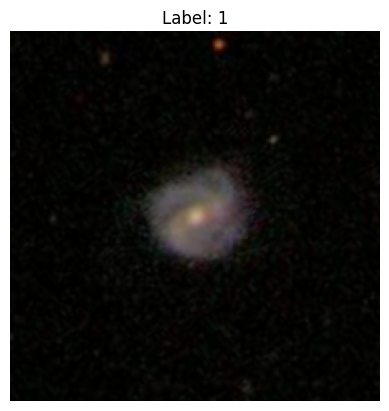

In [ ]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


augmentations added

In [ ]:
robust_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Rotation: galaxies have no "up"
    transforms.RandomRotation(degrees=180),

    # Brightness & contrast: exposure + distance
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4
    ),

    # Blur: atmospheric turbulence
    transforms.GaussianBlur(kernel_size=3),

    # Noise robustness (simulated via jitter + blur)
    transforms.ToTensor()
])


Create robust dataset

In [ ]:
train_dataset_robust = GalaxyDataset(
    train_df,
    transform=robust_transform
)

val_dataset_robust = GalaxyDataset(
    val_df,
    transform=baseline_transform  # validation is always clean
)


Visual Sanity check

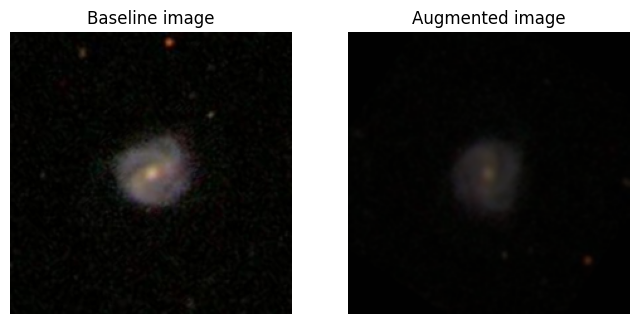

In [ ]:
import matplotlib.pyplot as plt

img_clean, _ = GalaxyDataset(train_df, baseline_transform)[0]
img_aug, _ = GalaxyDataset(train_df, robust_transform)[0]

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_clean.permute(1,2,0))
plt.title("Baseline image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_aug.permute(1,2,0))
plt.title("Augmented image")
plt.axis("off")

plt.show()


Creating data loaders

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_loader_robust = DataLoader(
    train_dataset_robust,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Defining the model for transfer learning

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)


Training loop

In [ ]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # Validation accuracy
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                preds = outputs.argmax(dim=1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        acc = correct / total

        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val Acc: {acc:.3f}")

    return acc


Training baseline model

In [ ]:
print("Training BASELINE model")
baseline_model = get_model()
baseline_acc = train_model(
    baseline_model,
    train_loader,
    val_loader
)


Training BASELINE model
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 58.6MB/s]


Epoch 1 | Loss: 0.3586 | Val Acc: 0.775
Epoch 2 | Loss: 0.0718 | Val Acc: 0.915
Epoch 3 | Loss: 0.0201 | Val Acc: 0.930


Training roboust model

In [ ]:
print("\nTraining ROBUST model")
robust_model = get_model()
robust_acc = train_model(
    robust_model,
    train_loader_robust,
    val_loader
)



Training ROBUST model
Epoch 1 | Loss: 0.3786 | Val Acc: 0.845
Epoch 2 | Loss: 0.1996 | Val Acc: 0.945
Epoch 3 | Loss: 0.1674 | Val Acc: 0.970


Evaluation function

In [ ]:
import torch
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


Confusion matrices

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Baseline
y_true_base, y_pred_base = evaluate_model(baseline_model, val_loader)

# Robust
y_true_robust, y_pred_robust = evaluate_model(robust_model, val_loader)


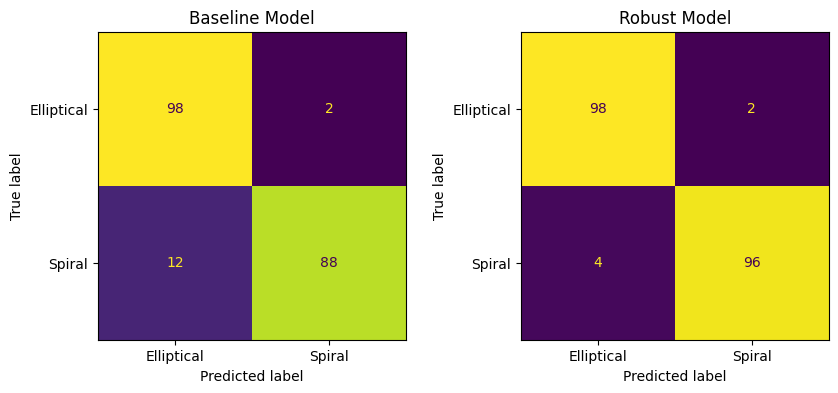

In [ ]:
labels = ["Elliptical", "Spiral"]

fig, axes = plt.subplots(1, 2, figsize=(10,4))

ConfusionMatrixDisplay(
    confusion_matrix(y_true_base, y_pred_base),
    display_labels=labels
).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Baseline Model")

ConfusionMatrixDisplay(
    confusion_matrix(y_true_robust, y_pred_robust),
    display_labels=labels
).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Robust Model")

plt.show()


Visualize predictions

In [ ]:
idx_to_label = {0: "Elliptical", 1: "Spiral"}

def show_predictions(model, dataset, n=6):
    model.eval()
    plt.figure(figsize=(12, 6))

    for i in range(n):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()

        plt.subplot(2, n//2, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(f"GT: {idx_to_label[label]}\nPred: {idx_to_label[pred]}")
        plt.axis("off")

    plt.show()


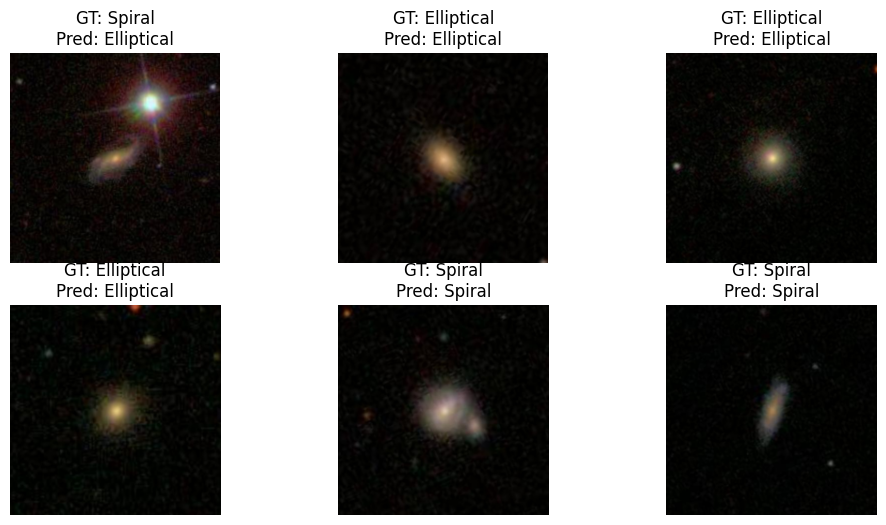

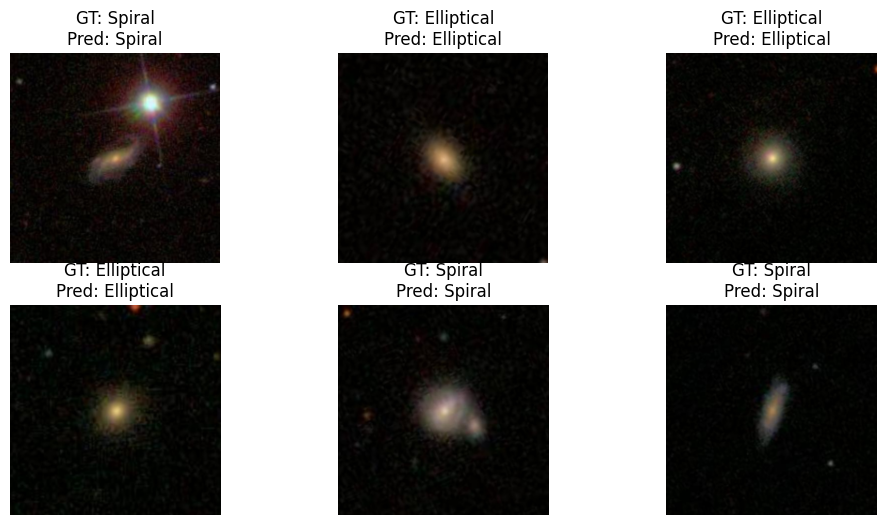

In [ ]:
show_predictions(baseline_model, val_dataset)
show_predictions(robust_model, val_dataset)


Save models

In [ ]:
torch.save(baseline_model.state_dict(), "baseline_galaxy_model.pth")
torch.save(robust_model.state_dict(), "robust_galaxy_model.pth")


Later to reload

In [ ]:
model = get_model()
model.load_state_dict(torch.load("robust_galaxy_model.pth"))


Extra work (yaaaaayyyy)

In [ ]:
def get_frozen_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Freeze all convolutional layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier (randomly initialized)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)


In [ ]:
frozen_model = get_frozen_model()

y_true_frozen, y_pred_frozen = evaluate_model(
    frozen_model,
    val_loader
)


In [ ]:
from sklearn.metrics import accuracy_score

frozen_acc = accuracy_score(y_true_frozen, y_pred_frozen)

print(f"Frozen pretrained accuracy: {frozen_acc:.3f}")


Frozen pretrained accuracy: 0.500


In [ ]:
print(f"Frozen pretrained accuracy: {frozen_acc:.3f}")
print(f"Baseline fine-tuned accuracy: {baseline_acc:.3f}")
print(f"Robust fine-tuned accuracy:   {robust_acc:.3f}")


Frozen pretrained accuracy: 0.500
Baseline fine-tuned accuracy: 0.930
Robust fine-tuned accuracy:   0.970


Confusion matrix of all three

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

CLASS_NAMES = ["Elliptical", "Spiral"]  # adjust if you named them differently

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


In [ ]:
y_true_frozen, y_pred_frozen = evaluate_model(
    frozen_model,
    val_loader
)


In [ ]:
y_true_base, y_pred_base = evaluate_model(
    baseline_model,
    val_loader
)


In [ ]:
y_true_robust, y_pred_robust = evaluate_model(
    robust_model,
    val_loader
)


Plotting all three

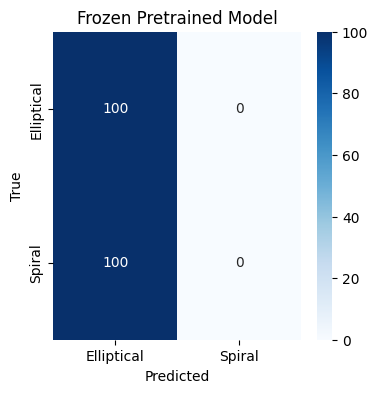

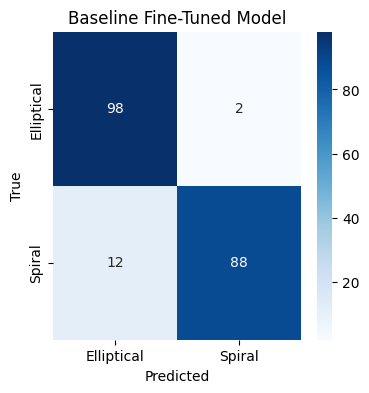

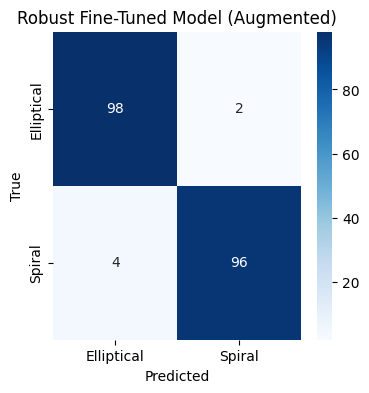

In [ ]:
plot_confusion(
    y_true_frozen,
    y_pred_frozen,
    "Frozen Pretrained Model"
)

plot_confusion(
    y_true_base,
    y_pred_base,
    "Baseline Fine-Tuned Model"
)

plot_confusion(
    y_true_robust,
    y_pred_robust,
    "Robust Fine-Tuned Model (Augmented)"
)
